In [1]:
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns

#for RBN
from keras.layers import Layer, Flatten, Dense
from keras import backend as K
from sklearn.metrics import classification_report


from sklearn.model_selection import StratifiedKFold
from keras import regularizers
from tensorflow.keras.utils import to_categorical


In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 1
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())


In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in MI feature selection method
feature_names = ['Root10DaysSeedling', 'Shoot10DaysSeedling', 'Root35DaysSeedling', 'Leaf45DaysOldPlant', 'Shoot35DaysSeedling', 
                 'Root14DaysSeedling', 'Root24DaysSeedling', 'Root17DaysSeedling', 'Root21DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot21DaysSeedling', 'PCC', 'Shoot14DaysSeedling', 'Root52DaysSeedling', 'Shoot17DaysSeedling', 
                 'Leaf21DaysSeedling', 'log_2FoldChange', 'ET', 'PPI', 'CoExpression' ]

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X_fs.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X_fs.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray
X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)

Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
1.0      1800
2.0      1296
3.0      1260
4.0      1218
5.0      1026
6.0      1008
7.0       930
8.0       912
9.0       880
10.0      798
11.0      792
12.0      759
13.0      729
14.0      720
15.0      702
16.0      693
17.0      672
18.0      640
19.0      625
20.0      570
21.0      546
22.0      506
23.0      483
24.0      448
25.0      432
26.0      384
27.0      360
28.0      360
29.0      320
30.0      312
         ... 
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      12
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      11
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
373.0      10
Length: 373, dtype: int64


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

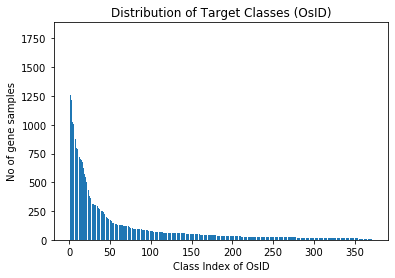

In [5]:
y_labelenc = LabelEncoder().fit_transform(Y)

from collections import Counter
# summarize distribution
counter = Counter(y_labelenc)

# sort counter by keys
counter = dict(sorted(counter.items()))


for k,v in counter.items():
 per = v / len(y_labelenc) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [7]:
# define the RBFLayer layer as a custom layer
class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [8]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [9]:
# define baseline model (RBFN)
def RBFN_model(input_dim):

    model = Sequential()
    model.add(Flatten(input_shape=(input_dim,)))
    #add the RBF layer
    model.add(RBFLayer(10, 0.5))
    
    model.add(Dense(60, input_dim=input_dim, activation='relu',bias_initializer='normal',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal',activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [10]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
# Define the number of folds for k-fold cross-validation
k = 2

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = RBFN_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=120, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Number of input features: 1
Fold: 1
Epoch 1/120
1846/1846 [==============================] - 16s 5ms/step - loss: 5.0166 - accuracy: 0.0387 - val_loss: 4.9756 - val_accuracy: 0.0315
Epoch 2/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.6929 - accuracy: 0.0664 - val_loss: 4.4508 - val_accuracy: 0.0917
Epoch 3/120
1846/1846 [==============================] - 8s 4ms/step - loss: 4.1408 - accuracy: 0.1202 - val_loss: 4.0766 - val_accuracy: 0.1373
Epoch 4/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8038 - accuracy: 0.1483 - val_loss: 3.8278 - val_accuracy: 0.1674
Epoch 5/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.5665 - accuracy: 0.1850 - val_loss: 3.6378 - val_accuracy: 0.1938
Epoch 6/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.3810 - accuracy: 0.2108 - val_loss: 3.4926 - val_accuracy: 0.1985
Epoch 7/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.2308 - accurac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.9575 - accuracy: 0.0498 - val_loss: 4.5398 - val_accuracy: 0.0889
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.1914 - accuracy: 0.1153 - val_loss: 4.0394 - val_accuracy: 0.1421
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6561 - accuracy: 0.2150 - val_loss: 3.3873 - val_accuracy: 0.2689
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8436 - accuracy: 0.3576 - val_loss: 2.7109 - val_accuracy: 0.4229
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.2178 - accuracy: 0.4628 - val_loss: 2.3511 - val_accuracy: 0.4836
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8379 - accuracy: 0.5373 - val_loss: 2.1028 - val_accuracy: 0.5331
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.6319 - accuracy: 0.5796 - val_loss: 1.9053 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 5.0291 - accuracy: 0.0418 - val_loss: 4.9055 - val_accuracy: 0.0436
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.6152 - accuracy: 0.0879 - val_loss: 4.3816 - val_accuracy: 0.1197
Epoch 3/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.7182 - accuracy: 0.2469 - val_loss: 3.3338 - val_accuracy: 0.3221
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8544 - accuracy: 0.3992 - val_loss: 2.7930 - val_accuracy: 0.4411
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.3491 - accuracy: 0.4948 - val_loss: 2.4350 - val_accuracy: 0.5373
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9901 - accuracy: 0.5617 - val_loss: 2.1315 - val_accuracy: 0.6066
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7288 - accuracy: 0.6057 - val_loss: 1.9728 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 14s 4ms/step - loss: 4.6808 - accuracy: 0.0913 - val_loss: 3.8593 - val_accuracy: 0.2568
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1973 - accuracy: 0.3680 - val_loss: 2.9732 - val_accuracy: 0.4117
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3770 - accuracy: 0.4969 - val_loss: 2.3291 - val_accuracy: 0.5399
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8193 - accuracy: 0.5819 - val_loss: 1.9423 - val_accuracy: 0.6255
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.5034 - accuracy: 0.6367 - val_loss: 1.7159 - val_accuracy: 0.6689
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.3179 - accuracy: 0.6740 - val_loss: 1.5255 - val_accuracy: 0.6673
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.1815 - accuracy: 0.7016 - val_loss: 1.4292 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 15s 5ms/step - loss: 4.9364 - accuracy: 0.0505 - val_loss: 4.4394 - val_accuracy: 0.0647
Epoch 2/120
1846/1846 [==============================] - 8s 4ms/step - loss: 3.8433 - accuracy: 0.2057 - val_loss: 3.4814 - val_accuracy: 0.3558
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.9361 - accuracy: 0.4073 - val_loss: 2.8249 - val_accuracy: 0.4810
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.3198 - accuracy: 0.4978 - val_loss: 2.3949 - val_accuracy: 0.5215
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.8876 - accuracy: 0.5943 - val_loss: 2.0846 - val_accuracy: 0.6299
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.5924 - accuracy: 0.6433 - val_loss: 1.8960 - val_accuracy: 0.6453
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3982 - accuracy: 0.6762 - val_loss: 1.7659 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 13s 5ms/step - loss: 4.5567 - accuracy: 0.0816 - val_loss: 4.0892 - val_accuracy: 0.0917
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.5856 - accuracy: 0.2354 - val_loss: 3.3027 - val_accuracy: 0.3362
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.7543 - accuracy: 0.4424 - val_loss: 2.6295 - val_accuracy: 0.5019
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.1028 - accuracy: 0.5622 - val_loss: 2.1319 - val_accuracy: 0.5782
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6587 - accuracy: 0.6292 - val_loss: 1.7779 - val_accuracy: 0.6548
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3783 - accuracy: 0.6832 - val_loss: 1.5600 - val_accuracy: 0.6935
Epoch 7/120
1846/1846 [==============================] - 8s 4ms/step - loss: 1.2092 - accuracy: 0.7083 - val_loss: 1.5056 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 15s 5ms/step - loss: 4.4979 - accuracy: 0.0886 - val_loss: 3.9382 - val_accuracy: 0.1844
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3838 - accuracy: 0.2727 - val_loss: 3.1461 - val_accuracy: 0.3571
Epoch 3/120
1846/1846 [==============================] - 8s 4ms/step - loss: 2.6158 - accuracy: 0.4437 - val_loss: 2.5534 - val_accuracy: 0.5285
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.0674 - accuracy: 0.5653 - val_loss: 2.1732 - val_accuracy: 0.6110
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6693 - accuracy: 0.6512 - val_loss: 1.9411 - val_accuracy: 0.6114
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.3944 - accuracy: 0.6907 - val_loss: 1.6709 - val_accuracy: 0.6986
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.2063 - accuracy: 0.7155 - val_loss: 1.5551 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.6354 - accuracy: 0.0760 - val_loss: 4.1511 - val_accuracy: 0.1199
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5940 - accuracy: 0.2092 - val_loss: 3.3133 - val_accuracy: 0.3017
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.7501 - accuracy: 0.4267 - val_loss: 2.6280 - val_accuracy: 0.5061
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1544 - accuracy: 0.5554 - val_loss: 2.2198 - val_accuracy: 0.5905
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7526 - accuracy: 0.6248 - val_loss: 1.9554 - val_accuracy: 0.6548
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4703 - accuracy: 0.6748 - val_loss: 1.7051 - val_accuracy: 0.6783
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2772 - accuracy: 0.7008 - val_loss: 1.6037 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.4638 - accuracy: 0.0861 - val_loss: 3.9839 - val_accuracy: 0.1439
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4643 - accuracy: 0.2195 - val_loss: 3.1462 - val_accuracy: 0.3881
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5103 - accuracy: 0.4733 - val_loss: 2.4119 - val_accuracy: 0.5201
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8587 - accuracy: 0.6132 - val_loss: 1.9293 - val_accuracy: 0.6438
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4573 - accuracy: 0.6736 - val_loss: 1.6696 - val_accuracy: 0.6766
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2162 - accuracy: 0.7128 - val_loss: 1.5400 - val_accuracy: 0.7021
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.0715 - accuracy: 0.7346 - val_loss: 1.3906 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.4787 - accuracy: 0.0987 - val_loss: 3.9806 - val_accuracy: 0.1679
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.5268 - accuracy: 0.2221 - val_loss: 3.3428 - val_accuracy: 0.3373
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8112 - accuracy: 0.3906 - val_loss: 2.7092 - val_accuracy: 0.3971
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1949 - accuracy: 0.5066 - val_loss: 2.2417 - val_accuracy: 0.5646
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7549 - accuracy: 0.6107 - val_loss: 1.9333 - val_accuracy: 0.6284
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4465 - accuracy: 0.6655 - val_loss: 1.7175 - val_accuracy: 0.6779
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2339 - accuracy: 0.7012 - val_loss: 1.5527 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.5482 - accuracy: 0.0740 - val_loss: 4.1748 - val_accuracy: 0.0796
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7383 - accuracy: 0.1584 - val_loss: 3.5694 - val_accuracy: 0.1679
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1185 - accuracy: 0.2818 - val_loss: 2.9795 - val_accuracy: 0.3727
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.4305 - accuracy: 0.4502 - val_loss: 2.3780 - val_accuracy: 0.5413
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.8580 - accuracy: 0.5764 - val_loss: 1.9377 - val_accuracy: 0.6266
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.4828 - accuracy: 0.6488 - val_loss: 1.7025 - val_accuracy: 0.6796
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.2508 - accuracy: 0.6962 - val_loss: 1.5053 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


1846/1846 [==============================] - 6s 2ms/step - loss: 4.5863 - accuracy: 0.0818 - val_loss: 4.1430 - val_accuracy: 0.1171
Epoch 2/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.7201 - accuracy: 0.1727 - val_loss: 3.5716 - val_accuracy: 0.2141
Epoch 3/120
1846/1846 [==============================] - 4s 2ms/step - loss: 3.0785 - accuracy: 0.3132 - val_loss: 2.9073 - val_accuracy: 0.3776
Epoch 4/120
1846/1846 [==============================] - 4s 2ms/step - loss: 2.4467 - accuracy: 0.4591 - val_loss: 2.4607 - val_accuracy: 0.4671
Epoch 5/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.9939 - accuracy: 0.5400 - val_loss: 2.0796 - val_accuracy: 0.5921
Epoch 6/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.6486 - accuracy: 0.6160 - val_loss: 1.8369 - val_accuracy: 0.6392
Epoch 7/120
1846/1846 [==============================] - 4s 2ms/step - loss: 1.3931 - accuracy: 0.6655 - val_loss: 1.7230 - val_accuracy: 0.65

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 10s 4ms/step - loss: 4.5383 - accuracy: 0.0765 - val_loss: 4.0447 - val_accuracy: 0.1307
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6419 - accuracy: 0.1797 - val_loss: 3.4902 - val_accuracy: 0.2216
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.0711 - accuracy: 0.3048 - val_loss: 2.8952 - val_accuracy: 0.3608
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4402 - accuracy: 0.4494 - val_loss: 2.3670 - val_accuracy: 0.5063
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.9916 - accuracy: 0.5377 - val_loss: 2.0658 - val_accuracy: 0.5589
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.6783 - accuracy: 0.5981 - val_loss: 1.7692 - val_accuracy: 0.6209
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.4530 - accuracy: 0.6333 - val_loss: 1.6498 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5883 - accuracy: 0.0757 - val_loss: 4.1398 - val_accuracy: 0.1289
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7106 - accuracy: 0.1765 - val_loss: 3.5525 - val_accuracy: 0.1892
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1770 - accuracy: 0.2579 - val_loss: 3.0621 - val_accuracy: 0.3001
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5465 - accuracy: 0.3987 - val_loss: 2.5066 - val_accuracy: 0.4825
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.0555 - accuracy: 0.4988 - val_loss: 2.1695 - val_accuracy: 0.5058
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.7907 - accuracy: 0.5559 - val_loss: 1.9296 - val_accuracy: 0.5875
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5794 - accuracy: 0.6007 - val_loss: 1.8528 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.6253 - accuracy: 0.0766 - val_loss: 4.1661 - val_accuracy: 0.1122
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.7526 - accuracy: 0.1627 - val_loss: 3.5763 - val_accuracy: 0.2075
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1002 - accuracy: 0.3062 - val_loss: 2.9549 - val_accuracy: 0.4319
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.4793 - accuracy: 0.4677 - val_loss: 2.4963 - val_accuracy: 0.4647
Epoch 5/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0603 - accuracy: 0.5392 - val_loss: 2.1513 - val_accuracy: 0.5459
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.7721 - accuracy: 0.5777 - val_loss: 1.9499 - val_accuracy: 0.5949
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.5702 - accuracy: 0.6075 - val_loss: 1.7850 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 8s 3ms/step - loss: 4.8472 - accuracy: 0.0639 - val_loss: 4.3705 - val_accuracy: 0.0882
Epoch 2/120
1846/1846 [==============================] - 5s 3ms/step - loss: 4.0090 - accuracy: 0.1258 - val_loss: 3.8492 - val_accuracy: 0.1586
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.4689 - accuracy: 0.2316 - val_loss: 3.3908 - val_accuracy: 0.2735
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9746 - accuracy: 0.3451 - val_loss: 2.9575 - val_accuracy: 0.3820
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.5243 - accuracy: 0.4380 - val_loss: 2.6296 - val_accuracy: 0.4403
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.1712 - accuracy: 0.5077 - val_loss: 2.3345 - val_accuracy: 0.5142
Epoch 7/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9148 - accuracy: 0.5434 - val_loss: 2.1116 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.5895 - accuracy: 0.0772 - val_loss: 4.1058 - val_accuracy: 0.0990
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 3.6683 - accuracy: 0.1797 - val_loss: 3.4970 - val_accuracy: 0.2541
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.9430 - accuracy: 0.3671 - val_loss: 2.7843 - val_accuracy: 0.4493
Epoch 4/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.3440 - accuracy: 0.4825 - val_loss: 2.3724 - val_accuracy: 0.5039
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.9552 - accuracy: 0.5444 - val_loss: 2.0340 - val_accuracy: 0.5573
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 1.6865 - accuracy: 0.5903 - val_loss: 1.8178 - val_accuracy: 0.5938
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 1.4929 - accuracy: 0.6250 - val_loss: 1.6575 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 9s 3ms/step - loss: 4.8734 - accuracy: 0.0541 - val_loss: 4.5750 - val_accuracy: 0.1237
Epoch 2/120
1846/1846 [==============================] - 6s 3ms/step - loss: 4.1446 - accuracy: 0.1327 - val_loss: 3.9599 - val_accuracy: 0.1608
Epoch 3/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.6660 - accuracy: 0.1788 - val_loss: 3.6110 - val_accuracy: 0.2011
Epoch 4/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.3667 - accuracy: 0.2133 - val_loss: 3.3756 - val_accuracy: 0.2172
Epoch 5/120
1846/1846 [==============================] - 5s 3ms/step - loss: 3.1189 - accuracy: 0.2555 - val_loss: 3.1553 - val_accuracy: 0.2779
Epoch 6/120
1846/1846 [==============================] - 5s 3ms/step - loss: 2.8956 - accuracy: 0.2988 - val_loss: 2.9495 - val_accuracy: 0.3030
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6840 - accuracy: 0.3365 - val_loss: 2.7446 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 11s 4ms/step - loss: 4.7196 - accuracy: 0.0731 - val_loss: 4.2214 - val_accuracy: 0.1157
Epoch 2/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.8238 - accuracy: 0.1590 - val_loss: 3.6498 - val_accuracy: 0.1822
Epoch 3/120
1846/1846 [==============================] - 9s 5ms/step - loss: 3.3201 - accuracy: 0.2295 - val_loss: 3.2070 - val_accuracy: 0.2733
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8351 - accuracy: 0.3343 - val_loss: 2.7592 - val_accuracy: 0.3732
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.4135 - accuracy: 0.4299 - val_loss: 2.4125 - val_accuracy: 0.4763
Epoch 6/120
1846/1846 [==============================] - 6s 3ms/step - loss: 2.0872 - accuracy: 0.5029 - val_loss: 2.1740 - val_accuracy: 0.4999
Epoch 7/120
1846/1846 [==============================] - 6s 3ms/step - loss: 1.8617 - accuracy: 0.5417 - val_loss: 1.9829 - val_a

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/120
1846/1846 [==============================] - 14s 4ms/step - loss: 4.8368 - accuracy: 0.0561 - val_loss: 4.4853 - val_accuracy: 0.0733
Epoch 2/120
1846/1846 [==============================] - 8s 5ms/step - loss: 4.0800 - accuracy: 0.1317 - val_loss: 3.9339 - val_accuracy: 0.1386
Epoch 3/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.6693 - accuracy: 0.1814 - val_loss: 3.6414 - val_accuracy: 0.2033
Epoch 4/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.3912 - accuracy: 0.2157 - val_loss: 3.4372 - val_accuracy: 0.2220
Epoch 5/120
1846/1846 [==============================] - 7s 4ms/step - loss: 3.1437 - accuracy: 0.2544 - val_loss: 3.1867 - val_accuracy: 0.2733
Epoch 6/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.8864 - accuracy: 0.3022 - val_loss: 2.9696 - val_accuracy: 0.2955
Epoch 7/120
1846/1846 [==============================] - 7s 4ms/step - loss: 2.6476 - accuracy: 0.3451 - val_loss: 2.7676 - val_a

In [12]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

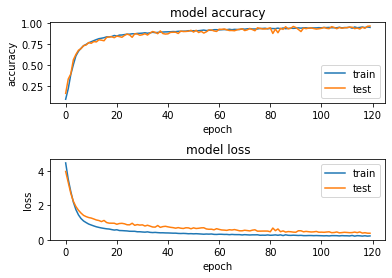

Final Test Accuracy: 0.9657256603240967


In [13]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [14]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))

424/424 [==============================] - 1s 2ms/step


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
          16       1.00      1.00      1.00       213
   

In [15]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os03g0179400         336              169       False
1  Os04g0659100         161              161        True
2  Os01g0686800          17               17        True
3  Os04g0107900          34               34        True
4  Os04g0517100           7                7        True


In [16]:
display(models_df)

,No of input features,Model accuracy
0,1,0.470
1,2,0.783
2,3,0.891
3,4,0.920
4,5,0.958
5,6,0.901
6,7,0.931
7,8,0.921
8,9,0.925
9,10,0.966
